# MNIST Classification Task

In [98]:
# Utility Functions we'll use later on

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [ ]:
# Download MNIST dataset from Scikit-learn
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

In [3]:
# Lets check out the arrays
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

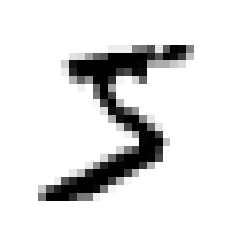

In [5]:
# Lets peek one image
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [6]:
y[0] # It is indeed a 5

'5'

In [7]:
# Note the label is a string so we need to cast it to an integer
import numpy as np
y = y.astype(np.uint8)

In [11]:
# Set aside a test set!
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Binary Classification

In [13]:
# Lets start with a binary classifier to detect 5 or not 5:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier(random_state=42)
sgd_classifier.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [15]:
# Now we can use it to make predictions.
sgd_classifier.predict([some_digit])

array([ True])

In [16]:
# Implementing Cross-Validation yourself instead of using SciKit
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

stratified_k_folds = StratifiedKFold(n_splits = 3, random_state = 42, shuffle=True)

for train_index, test_index in stratified_k_folds.split(X_train, y_train_5):
    clone_classifier = clone(sgd_classifier)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_classifier.fit(X_train_folds, y_train_folds)
    y_predictions = clone_classifier.predict(X_test_fold)
    n_correct = sum(y_predictions == y_test_fold)
    print(n_correct / len(y_predictions))

0.9669
0.91625
0.96785


In [17]:
# Now lets use cross_val_score() to evaluate our SGDClassifier model
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_classifier, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [18]:
# Lets test the performance on a classifier that always guesses 'NOT 5'
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
# This demonstrates that accuracy is a bad performance metric for classification models, especially for skewed datasets.

array([0.91125, 0.90855, 0.90915])

In [19]:
# Instead we need to use a confusion matrix to evaluate the performance of our model

from sklearn.model_selection import cross_val_predict
# cross_val_predict works like cross_val_score but returns the predictions made on each test fold.

y_train_predictions = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3)

# Now we are ready to get the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_predictions)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [20]:
# We see above our confusion matrix. Each row is an actual class, each column is a predicted class.
# The first row is our 'not 5' class, with 53892 correct classifications (true negatives), 
# and 687 wrong classifications (false positives)
# The second row is our '5' class, with 1891 wrong classifications as non-5s (false negatives)
# and 3530 correct classifications as 5s (true positives)

In [23]:
# Now let's calculate the precision and recall of the classifier
from sklearn.metrics import precision_score, recall_score

In [24]:
precision_score(y_train_5, y_train_predictions) # == 3530 / (3530 + 687)

0.8370879772350012

In [25]:
recall_score(y_train_5, y_train_predictions) # == 3530 / (3530 + 1891)

0.6511713705958311

In [26]:
# Now let's calculate the F1 score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_predictions)

0.7325171197343846

In [27]:
# Now we want to change the threshold of our SGD Classifier's decision function
# SKLearn won't let us do this directly, but we can call it's decision_function() instead of predict()
y_scores = sgd_classifier.decision_function([some_digit])
y_scores

array([2164.22030239])

In [29]:
threshold = 0
y_some_digit_prediction = (y_scores > threshold)
y_some_digit_prediction

array([ True])

In [30]:
# We can see that with the threshold set to 0 (the default threshold) it correctly classifies the 5

# Now let's increase the threshold
threshold = 8000
y_some_digit_prediction = (y_scores > threshold)
y_some_digit_prediction

array([False])

In [31]:
# And this confirms that increasing the threshold decreases the recall as our '5 classifier' now cannot detect the 5

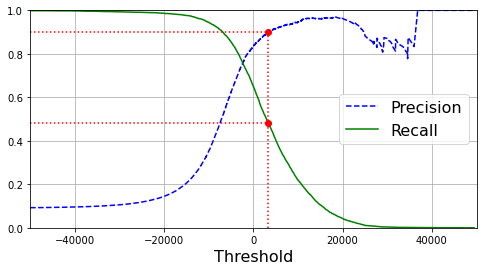

In [35]:
# Let's do the following cross-validation to decide on which threshold value to use
y_scores = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

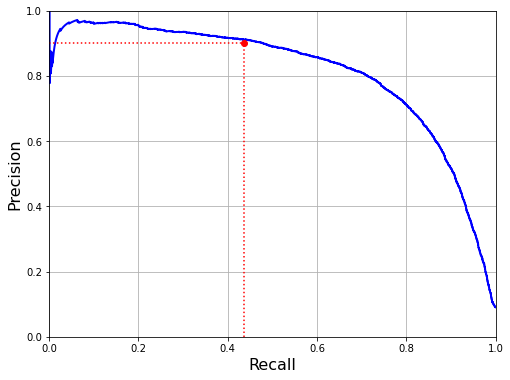

In [40]:
# We can also plot precision vs. recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
plt.show()

In [41]:
# Let's say we want to aim for 90% precision, we use the threshold_90_precision above and run the following:
y_train_predictions_90 = (y_scores >= threshold_90_precision)
# Now let's check what the precision and recall scores are

In [42]:
precision_score(y_train_5, y_train_predictions_90)

0.9000345901072293

In [43]:
recall_score(y_train_5, y_train_predictions_90)

0.4799852425751706

In [44]:
# We now have a 90% precision classifier, but with 43% recall. This isn't useful.

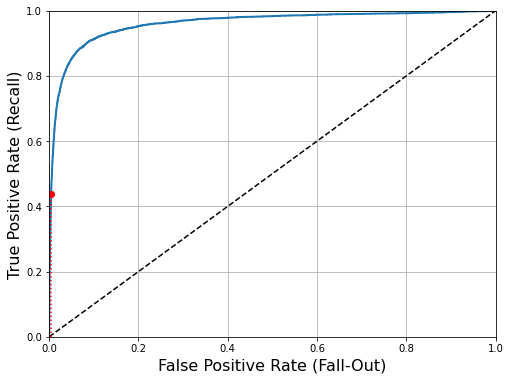

In [45]:
# Next let's plot the ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0,1], 'k--') # Dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [46]:
# As we can see from the graph above there is a trade off, the higher the TPR/Recall, the FPR increases too.
# Note that the dotted line represents the ROC Curve of a purely random classifier, a good classifier stays away
# from that line as possible towards the top left corner.

In [47]:
# Next let's computer the ROC AUC (Area under the Curve)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [49]:
# Next we’ll try a RandomForestClassifier and compare its ROC curve and ROC AUC Score
# Note that the RandomForestClassifier doesn't have a decision_function()
# instead we need to use its predict_proba() function.
# Generally SKLearn classifiers have one or the other or both.

from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier(random_state=42)
y_probabilities_rfc = cross_val_predict(random_forest_classifier, X_train, y_train_5, cv=3, method="predict_proba")

In [50]:
# The roc_curve() function expects labels and scores but instead of scores we can give it probabilities
y_scores_rfc = y_probabilities_rfc[:,1] # score = proba of positive class
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_train_5, y_scores_rfc)

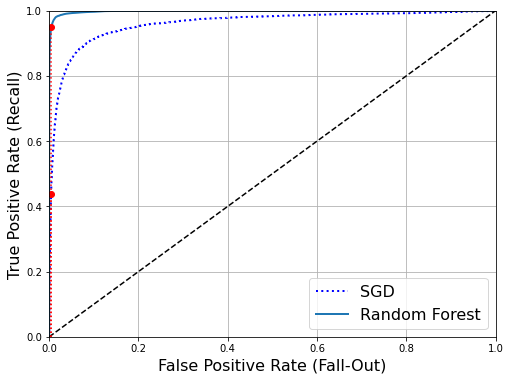

In [53]:
# Now we can plot the ROC Curve for the RF Classifier and compare it to the SGD Classifier
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_rfc, tpr_rfc, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [55]:
# From our graph we can see the RandomForestClassifier is superior to the SGDClassifier 
# because the ROC Curve is much closer to the top left corner and has a greater AUC value.
roc_auc_score(y_train_5, y_scores_rfc)

0.9983436731328145

In [56]:
# Let's look at the precision and recall scores of the RandomForestClassifier
y_train_predictions_rfc = cross_val_predict(random_forest_classifier, X_train, y_train_5, cv=3)

In [57]:
# RFC Precision
precision_score(y_train_5, y_train_predictions_rfc)

0.9905083315756169

In [58]:
# RFC Recall
recall_score(y_train_5, y_train_predictions_rfc)

0.8662608374838591

In [ ]:
# Very good stuff!

# Multiclass Classification

In [60]:
# Let's try using a SVM classifier
from sklearn.svm import SVC
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train) # Notice we are now training on the full set, not just 5s
svm_classifier.predict([some_digit])

array([5], dtype=uint8)

In [74]:
# Under the hood, SKLearn used the OvO strategy (it trained 45 binary classifiers)

In [62]:
# Here we can see it's returning 10 scores per instance, i.e. one per class
some_digit_scores = svm_classifier.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [63]:
np.argmax(some_digit_scores)

5

In [64]:
svm_classifier.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [65]:
# We can force SKLearn to use the OVR or OvO strategy if we want
from sklearn.multiclass import OneVsRestClassifier
ovr_classifier = OneVsRestClassifier(SVC())
ovr_classifier.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [66]:
ovr_classifier.predict([some_digit])

array([5], dtype=uint8)

In [68]:
len(ovr_classifier.estimators_) # Notice that here we only have 10 classifiers

10

In [70]:
# Training an SGD Classifier or Random Forest Classifier is just as easy
sgd_classifier.fit(X_train, y_train)
sgd_classifier.predict([some_digit])

array([3], dtype=uint8)

In [71]:
# The decision_function() now returns 1 value per class
sgd_classifier.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [72]:
# Next let's evaluate the SGD Classifiers accuracy
cross_val_score(sgd_classifier, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [76]:
# This accuracy is pretty good, but we can do even better if we scale the inputs
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_classifier, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

In [77]:
# First we look at the confusion matrix
y_train_predictions = cross_val_predict(sgd_classifier, X_train_scaled, y_train, cv=3)
confusion_matrix = confusion_matrix(y_train, y_train_predictions)

In [78]:
confusion_matrix

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

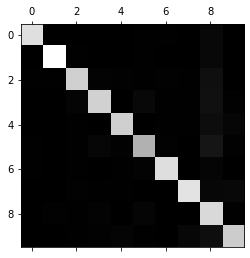

In [79]:
# Let's look at an image representation
plt.matshow(confusion_matrix, cmap=plt.cm.gray)
plt.show()

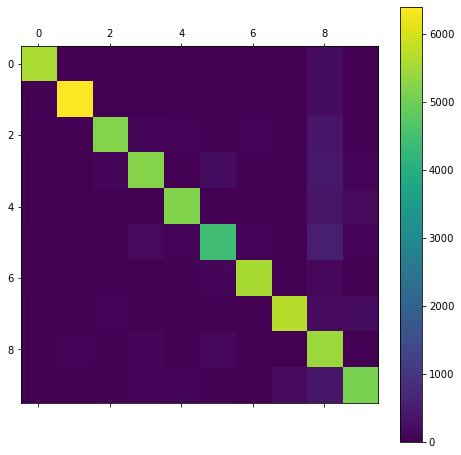

In [82]:
# since sklearn 0.22, you can use sklearn.metrics.plot_confusion_matrix()
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    
plot_confusion_matrix(confusion_matrix)

In [80]:
# This looks good, but we need to focus on the errors.
# First we need to divide each value in the matrix by the number of images in
# the corresponding class to compare error rates instead of absolute number of errors.
row_sums = confusion_matrix.sum(axis=1, keepdims=True)
norm_confusion_matrix = confusion_matrix / row_sums

In [81]:
# Let's also fill the diagonal with zeros to keep only the errors
np.fill_diagonal(norm_confusion_matrix, 0)

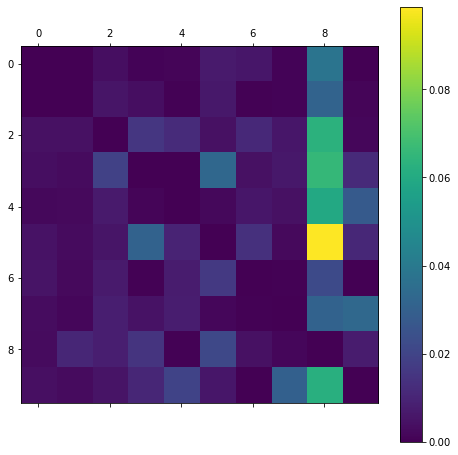

In [83]:
# Now let's take a look at the plot again
plot_confusion_matrix(norm_confusion_matrix)

Here we can clearly see what kinds of errors the classifier makes.

Remember rows represent actual classes, while columns represent predicted classes.

The column for 8 shows that many images get classified incorrectly as 8s,
however the row for class 8 is not that bad telling us that in general actual 8s do get classified as 8s.

We can also see that 3s and 5s are getting incorrectly classified in both directions.

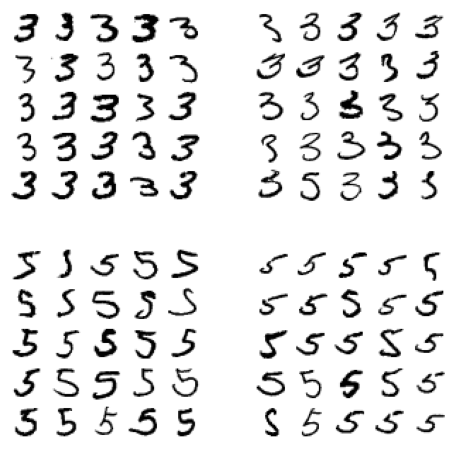

In [87]:
# Let's look at some of the individual errors to gain more insights
class_a, class_b = 3, 5
X_aa = X_train[(y_train == class_a) & (y_train_predictions == class_a)]
X_ab = X_train[(y_train == class_a) & (y_train_predictions == class_b)]
X_ba = X_train[(y_train == class_b) & (y_train_predictions == class_a)]
X_bb = X_train[(y_train == class_b) & (y_train_predictions == class_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

The left column shows images that were classified as 3s, the right column shows images that were classified as 5s.
The bottom left and top right are the incorrect classifications.

Some digits are so badly written that even a human would have trouble classifying them, but most misclassified images
are obviously wrong to us and it's hard to understand why the classifier made those mistakes.

In this case, the reason these errors exist is because the SGD Classifier is a simple linear model, all it does is assign a weight per class to each pixel, and when it sees an image all it does is sum up the weighted
pixel intensities to get a score for each class.

So since 3s and 5s only differ by a few pixels, this model will easily confuse them.

# Multilabel Classifcation System

In [88]:
# Let's create a system that classifies values >= 7 and odd values
from sklearn.neighbors import KNeighborsClassifier

y_train_large_values = (y_train >= 7)
y_train_odd_values = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large_values, y_train_odd_values]

knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_multilabel)
# Note that the knn_classifier supports multilabel classification, but not all classifiers do.

KNeighborsClassifier()

In [89]:
knn_classifier.predict([some_digit])

array([[False,  True]])

In [90]:
# This correctly classified our 5 as not large, but it is odd!

In [91]:
# Next we need to evaluate our multilabel classifier,
# Let's do this by finding the F1 score of each label and taking the average.
y_train_knn_predictions = cross_val_predict(knn_classifier, X_train, y_multilabel, cv=3)

In [92]:
# Taking the average assumes all labels are equally important
f1_score(y_multilabel, y_train_knn_predictions, average="macro")

0.976410265560605

In [93]:
# We can also take a weighted average in the event that not all labels are equal (ex. if there are more than the other)
f1_score(y_multilabel, y_train_knn_predictions, average="weighted")

0.9778357403921755

In [94]:
# Both look pretty good!

# Multioutput Multiclass Classification (Multioutput Classification)

In [104]:
# Next let's build a multioutput Classification system to remove noise from images
# Let's start by taking the MNIST training and test set and adding noise to the images.
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_noisy = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_noisy = X_test + noise

y_train_clean = X_train
y_test_clean = X_test

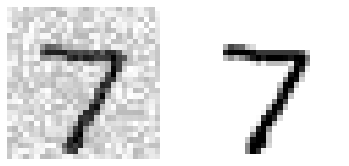

In [106]:
# Next let's be a little naught and look at the test set just to illustrate what we're working with

some_index = 0
plt.subplot(121); plot_digit(X_test_noisy[some_index])
plt.subplot(122); plot_digit(y_test_clean[some_index])
plt.show()

In [107]:
# On the left is our input noisy image
# On the right is our clean unmodified image

In [108]:
# Let's train the classifier and denoise our input image
knn_classifier.fit(X_train_noisy, y_train_clean)

KNeighborsClassifier()

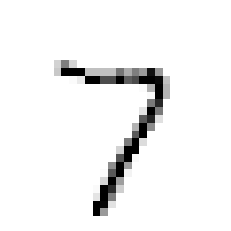

In [109]:
clean_digit = knn_classifier.predict([X_test_noisy[some_index]])
plot_digit(clean_digit)

In [110]:
# Not too bad at all!

# Chapter 3 Exercises